In [2]:
import os
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image

import data
import models
import pvnet_utils

ROOT_DIR = "../dataset/LINEMOD"

%matplotlib inline

### Split files into test and train split

In [3]:
X_train, X_test, y_train, y_test = pvnet_utils.get_test_train_split(ROOT_DIR,['duck', 'cat', 'lamp'], 
                                                                    test_size=0.33, 
                                                                    random_state=2, 
                                                                    shuffle=True)

X = X_train[:1, :]
y = y_train[:1]

print(X)
print(y)

[['../dataset/LINEMOD/cat/JPEGImages/000968.jpg'
  '../dataset/LINEMOD/cat/mask/0968.png'
  '../dataset/LINEMOD/cat/labels/000968.txt']]
['cat']


### Create Dataset and Dataloader and visualize some batches

In [4]:
dataset = data.LineModReader((X_train, y_train))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

### Visualize a batch

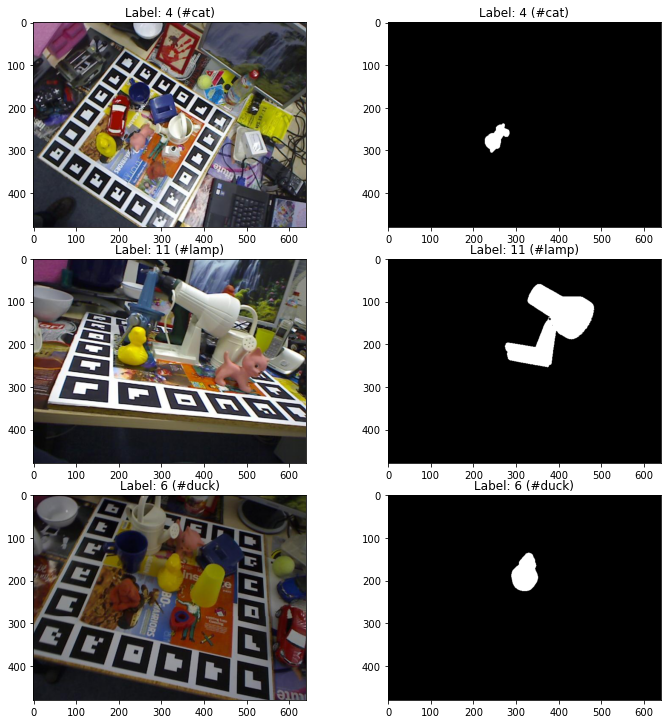

In [5]:
dataset.show_batch(3)

/Users/nicholasmoy/miniconda3/envs/231a/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([13, 240, 320])
torch.Size([1, 240, 320])


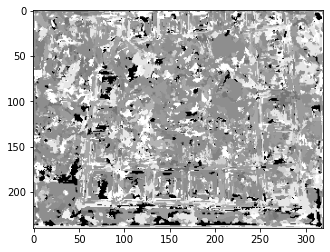

In [30]:
from torchsummary import summary
reload(models)
model = torchvision.models.resnet18()
# summary(model,(3,640,480))
# Test model
newmodel = models.PvNet(
    num_classes = 12,
    num_keypoints = 9,
    norm_layer = None,
    output_class = True,
    output_vector = False,
    pretrained = True
)
# summary(newmodel,(3,640,480))

# Outputs
class_out = (newmodel(torch.unsqueeze(dataset[0][0],0)))[0][0]
print(class_out.size())

# Get top class, scale by 12 for vis diff
classviz = torch.topk(class_out, 1, dim=0)[1] * 12
print(classviz.size())

plt.imshow(dataset.tensorToImage(classviz.type(torch.FloatTensor)),cmap='gray')
plt.show()


# newmodel(dataset)